In [3]:
import numpy as np
from glob import glob
import pandas as pd
import json

import sys
sys.path.append('../libml')

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [71]:
def summarize_gradient_table(model='erm', dataset='cifar10', sample_size=5000):
    if model == 'erm':
        batch_factor = 64.
    else:
        batch_factor = 1.
        
    for i in range(5):
        path_list = sorted(glob('../results/{}/{}.{}@{}-1/gradients_06553600.txt'.format(model, dataset,i+1, sample_size)))
        tmp = []
        #print(path_list)
        for ind, path in enumerate(path_list):
            f = json.load(open(path, "r"))
            df_tmp = pd.DataFrame(f)
            df_tmp.columns=['epoch_{}'.format((ind+1)*10)]
            tmp.append(df_tmp)
        if i == 0:
            df = pd.concat(tmp, axis=1)*batch_factor/5
        else:
            df = df + pd.concat(tmp, axis=1)*batch_factor/5
        #print(i)
        #print('-'*30)
        #print(df)
    return df

# Distribution of gradients vs epochs
## CIFAR10

In [72]:
'''
CIFAR 5000
'''
erm_5k_df = summarize_gradient_table(model='erm', dataset='cifar10', sample_size=25000)
mixup_5k_df = summarize_gradient_table(model='mixup', dataset='cifar10', sample_size=25000)
droid_5k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar10', sample_size=25000)
'''
CIFAR 50000
'''
erm_50k_df = summarize_gradient_table(model='erm', dataset='cifar10', sample_size=50000)
mixup_50k_df = summarize_gradient_table(model='mixup', dataset='cifar10', sample_size=50000)
droid_50k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar10', sample_size=50000)

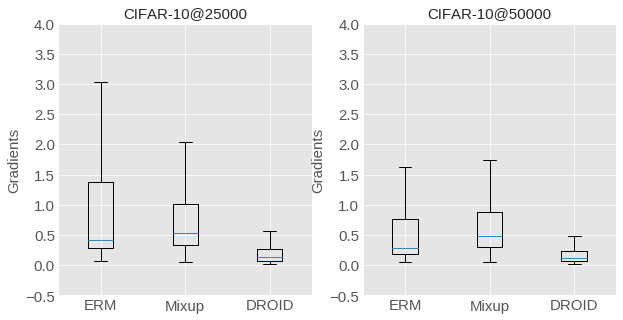

In [73]:
names=['ERM','Mixup','DROID']

df_list=[erm_5k_df, mixup_5k_df, droid_5k_df]
box_list = [df_list[0]['epoch_10'], df_list[1]['epoch_10'], df_list[2]['epoch_10']]
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('CIFAR-10@25000', fontsize=15)
plt.boxplot(box_list, showfliers=False)
plt.xticks([1,2,3],[names[i] for i in range(len(df_list))], fontsize=15)
plt.ylabel('Gradients', fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.5,4)


df_list=[erm_50k_df, mixup_50k_df, droid_50k_df]
box_list = [df_list[i]['epoch_10'] for i in range(len(df_list))]
plt.subplot(122)
plt.title('CIFAR-10@50000', fontsize=15)
plt.boxplot(box_list, showfliers=False)
plt.xticks([1,2,3],[names[i] for i in range(len(df_list))], fontsize=15)
plt.ylabel('Gradients', fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.5,4)


plt.savefig('/home/kwy/Desktop/boxplot_cifar10.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

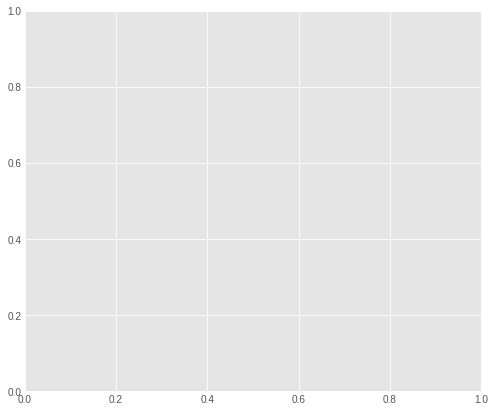

In [43]:
colors=['green','red', 'dodgerblue']
df_list=[erm_5k_df, mixup_5k_df, droid_5k_df]
names=['ERM','Mixup','DROID']

plt.figure(figsize=(18,7))
plt.subplot(121)
for i in range(len(colors)):
    ymean, yerr = df_list[i].mean(), df_list[i].std()
    x_list = np.linspace(10,100, 10)
    plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Gradients')
plt.ylim(-1, 5)
plt.title('CIFAR-10@5000')

df_list=[erm_50k_df, mixup_50k_df, droid_50k_df]
plt.subplot(122)
for i in range(len(colors)):
    ymean, yerr = df_list[i].mean(), df_list[i].std()
    x_list = np.linspace(10,100, 10)
    plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])

    
plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Gradients')
plt.ylim(-1, 5)
plt.title('CIFAR-10@50000')
#plt.savefig('figures/cifar10_grad_vs_epoch.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

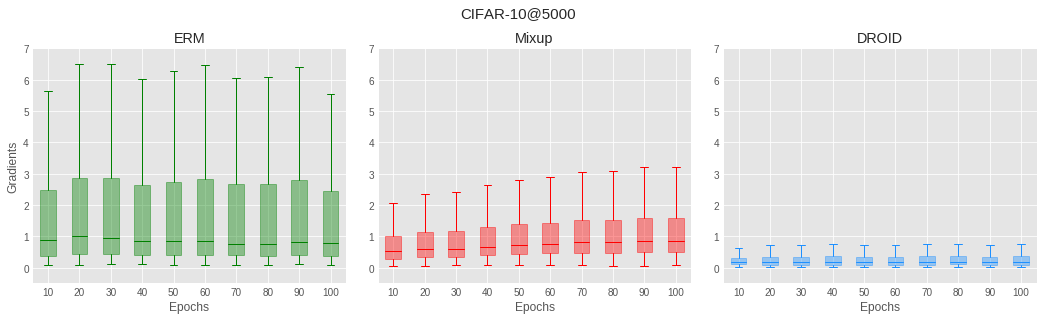

In [7]:
colors=['green','red', 'dodgerblue']
df_list=[erm_5k_df, mixup_5k_df, droid_5k_df]
names=['ERM','Mixup','DROID']


plt.figure(figsize=(18,4.5))
plt.ylabel('gradients')
plt.xticks([])
plt.yticks([])
for i in range(len(colors)):
    plt.subplot(1,3,i+1)
    if i==0: plt.ylabel('Gradients')
    plt.title(names[i])
    box_list = [df_list[i]['epoch_'+ str(epoch)]for epoch in range(10,101,10)]
    bp = plt.boxplot(box_list, showfliers=False, patch_artist=True)
    plt.xticks(list(range(1,11,1)),list(range(10,101,10)))
    plt.xlabel('Epochs')
    plt.ylim(-0.5,7)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=colors[i])

    for patch in bp['boxes']:
        patch.set(facecolor=colors[i], alpha=0.4)


plt.subplots_adjust(wspace=0.1, top=0.85)
plt.suptitle('CIFAR-10@5000', fontsize=15)
plt.show()

In [9]:
def accuracy_by_epoch(dataset='cifar10', model='erm', sample_size='50000', result_path='../results'):
    '''
    Calculate the mean and standard deviation of accuracy in each 10 epochs
    '''
    if dataset == 'cifar10':
        sample_size_list = [2500,5000,25000,50000] # [100,500,1000,2500,5000,25000,50000]
    elif dataset == 'cifar100':
        sample_size_list = [2500,5000,25000,50000] # [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"
        
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    path_list = sorted(
                 glob(
                       result_path+'/{}/{}.*@{}-1/accuracies.txt'.format(model, dataset, sample_size)
                 ))
    tmp = []
    for path in path_list:
        f = json.load(open(path, "r"))
        tmp.append(pd.DataFrame(f, index=split_list))
    
    assert len(tmp) == 5, 'Check the number of experiments (seeds), we run 5 times'
    tmp = pd.concat(tmp, sort=False)
    tmp_test = tmp.loc['test']
    print(tmp_test.mean()['epoch0'])
    tmp_dict = {'data': dataset,
                'model': model,
                'sample': sample_size,
                'mean': list(tmp_test.mean()),
                'std': list(tmp_test.std())}
    df = df.append(tmp_dict, ignore_index=True)

    return df

In [125]:
erm_5k_acc = accuracy_by_epoch(dataset='cifar10', model='erm', sample_size=5000)
mixup_5k_acc = accuracy_by_epoch(dataset='cifar10', model='mixup', sample_size=5000)
droid_5k_acc = accuracy_by_epoch(dataset='cifar10', model='l2_0.008', sample_size=5000)
erm_5k_acc['mean']

10.094
10.452
9.862


0    [10.094, 11.614, 27.669999999999998, 66.09, 76...
Name: mean, dtype: object

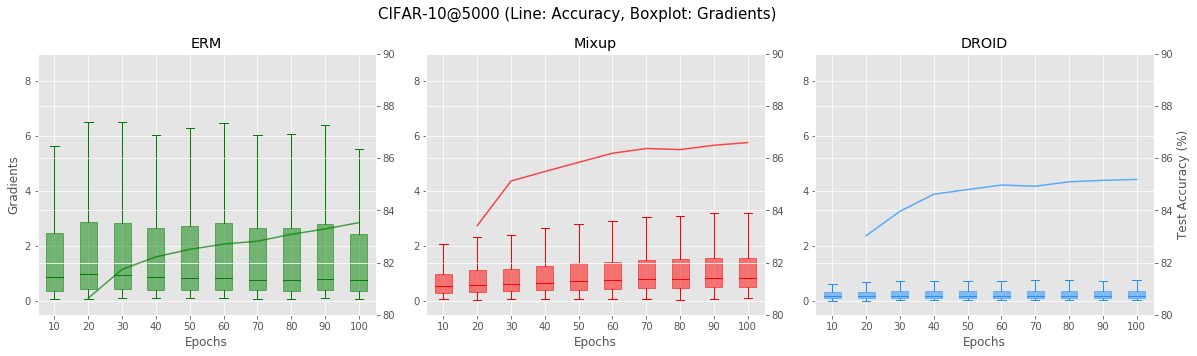

In [180]:
colors=['green','red', 'dodgerblue']
df_list=[erm_5k_df, mixup_5k_df, droid_5k_df]
acc_list=[erm_5k_acc, mixup_5k_acc, droid_5k_acc]
names=['ERM','Mixup','DROID']


plt.figure(figsize=(20,5))
plt.ylabel('gradients')
plt.xticks([])
plt.yticks([])
for i in range(len(colors)):
    # axis 1
    ax1 = plt.subplot(1,3,i+1)
    if i==0: ax1.set_ylabel('Gradients')
    plt.title(names[i])
    box_list = [df_list[i]['epoch_'+ str(epoch)]for epoch in range(10,101,10)]
    bp = ax1.boxplot(box_list, showfliers=False, patch_artist=True)
    plt.xticks(list(range(1,11,1)),list(range(10,101,10)))
    plt.xlabel('Epochs')
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=colors[i])

    for patch in bp['boxes']:
        patch.set(facecolor=colors[i], alpha=0.5)
    
    # axis 2
    ax2 = ax1.twinx()
    if i==2: ax2.set_ylabel('Test Accuracy (%)')
    ax2.plot(range(2,11,1), acc_list[i]['mean'][0][10:100:10], color=colors[i], alpha=0.7)
    #plt.fill_between
    
    
    #axis range
    ymax = 9
    ymin = -0.5
    ax1.axis([0.5, 10.5, ymin, ymax])
    ax2.axis([0.5, 10.5, 80, ymax*10])
    

plt.subplots_adjust(wspace=0.15, top=0.85)
plt.suptitle('CIFAR-10@5000 (Line: Accuracy, Boxplot: Gradients)', fontsize=15)
plt.savefig('../acc_and_grad.pdf', dpi=300)
plt.show()

## CIFAR100

'''
CIFAR 5000
'''
erm_100_5k_df = summarize_gradient_table(model='erm', dataset='cifar100', sample_size=5000)
mixup_100_5k_df = summarize_gradient_table(model='mixup', dataset='cifar100', sample_size=5000)
droid_100_5k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar100', sample_size=5000)
'''
CIFAR 50000
'''
erm_100_50k_df = summarize_gradient_table(model='erm', dataset='cifar100', sample_size=50000)
mixup_100_50k_df = summarize_gradient_table(model='mixup', dataset='cifar100', sample_size=50000)
droid_100_50k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar100', sample_size=50000)

colors=['green','red', 'dodgerblue']
df_list=[erm_100_5k_df, mixup_100_5k_df, droid_100_5k_df]
names=['ERM','Mixup','DROID']

plt.figure(figsize=(18,7))
plt.subplot(121)
for i in range(len(colors)):
    ymean, yerr = df_list[i].mean(), df_list[i].std()
    x_list = np.linspace(10,100, 10)
    plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Gradients')
plt.ylim(-1, 5)
plt.title('CIFAR-100@5000')

df_list=[erm_100_50k_df, mixup_100_50k_df, droid_100_50k_df]
plt.subplot(122)
for i in range(len(colors)):
    ymean, yerr = df_list[i].mean(), df_list[i].std()
    x_list = np.linspace(10,100, 10)
    plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])

    
plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Gradients')
plt.ylim(-1, 5)
plt.title('CIFAR-100@50000')
plt.savefig('figures/cifar100_grad_vs_epoch.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

# Density of gradients vs epochs
## CIFAR100

In [76]:
'''
CIFAR-100 2500
'''
erm_5k_df = summarize_gradient_table(model='erm', dataset='cifar100', sample_size=25000)
mixup_5k_df = summarize_gradient_table(model='mixup', dataset='cifar100', sample_size=25000)
droid_5k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar100', sample_size=25000)
'''
CIFAR-100 50000
'''
erm_50k_df = summarize_gradient_table(model='erm', dataset='cifar100', sample_size=50000)
mixup_50k_df = summarize_gradient_table(model='mixup', dataset='cifar100', sample_size=50000)
droid_50k_df = summarize_gradient_table(model='l2_0.008', dataset='cifar100', sample_size=50000)

In [61]:
# print(erm_5k_df)
# print(erm_50k_df)

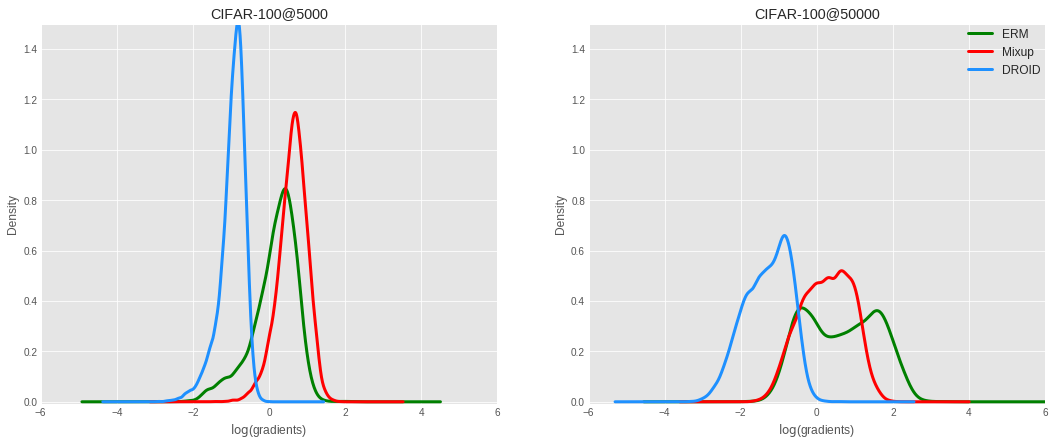

In [62]:
plt.figure(figsize=(18,7))
plt.subplot(121)

np.log(erm_5k_df['epoch_10']).plot.density(c=colors[0], label=names[0], linewidth=3)
np.log(mixup_5k_df['epoch_10']).plot.density(c=colors[1], label=names[1], linewidth=3)
np.log(droid_5k_df['epoch_10']).plot.density(c=colors[2], label=names[2], linewidth=3)
# plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlim(-6, 6)
plt.ylim(-0.01, 1.5)
plt.xlabel('$\log$(gradients)')
plt.ylabel('Density')
plt.title('CIFAR-100@5000')

plt.subplot(122)
np.log(erm_50k_df['epoch_10']).plot.density(c=colors[0], label=names[0], linewidth=3)
np.log(mixup_50k_df['epoch_10']).plot.density(c=colors[1], label=names[1], linewidth=3)
np.log(droid_50k_df['epoch_10']).plot.density(c=colors[2], label=names[2], linewidth=3)
plt.xlim(-6, 6)
plt.ylim(-0.01, 1.5)
plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlabel('$\log$(gradients)')
# plt.ylabel('Density')
plt.title('CIFAR-100@50000')
#plt.savefig('figures/cifar10_density.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

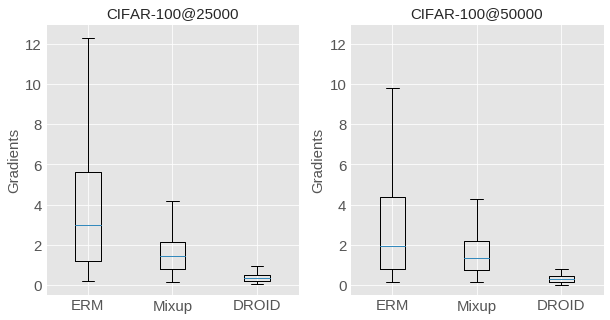

In [82]:
names=['ERM','Mixup','DROID']

df_list=[erm_5k_df, mixup_5k_df, droid_5k_df]
box_list = [df_list[0]['epoch_10'], df_list[1]['epoch_10'], df_list[2]['epoch_10']]
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('CIFAR-100@25000', fontsize=15)
plt.boxplot(box_list, showfliers=False)
plt.xticks([1,2,3],[names[i] for i in range(len(df_list))], fontsize=15)
plt.ylabel('Gradients', fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.5,13)


df_list=[erm_50k_df, mixup_50k_df, droid_50k_df]
box_list = [df_list[i]['epoch_10'] for i in range(len(df_list))]
plt.subplot(122)
plt.title('CIFAR-100@50000', fontsize=15)
plt.boxplot(box_list, showfliers=False)
plt.xticks([1,2,3],[names[i] for i in range(len(df_list))], fontsize=15)
plt.ylabel('Gradients', fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.5,13)


plt.savefig('/home/kwy/Desktop/boxplot_cifar100.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [64]:
erm_5k_df

,epoch_10
0,1.616761
1,1.727215
2,1.608556
3,1.825007
4,1.845792
5,2.266092
6,1.870451
7,1.521092
8,2.344869
9,0.554499


## CIFAR100

plt.figure(figsize=(18,7))
plt.subplot(121)

np.log(erm_100_5k_df['epoch_100']).plot.density(c=colors[0], label=names[0], linewidth=3)
np.log(mixup_100_5k_df['epoch_100']).plot.density(c=colors[1], label=names[1], linewidth=3)
np.log(droid_100_5k_df['epoch_100']).plot.density(c=colors[2], label=names[2], linewidth=3)
# plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlim(-6, 6)
plt.ylim(-0.01, .7)
plt.xlabel('$\log$(gradients)')
plt.ylabel('Density')
plt.title('CIFAR-100@5000')

plt.subplot(122)
np.log(erm_100_50k_df['epoch_100']).plot.density(c=colors[0], label=names[0], linewidth=3)
np.log(mixup_100_50k_df['epoch_100']).plot.density(c=colors[1], label=names[1], linewidth=3)
np.log(droid_100_50k_df['epoch_100']).plot.density(c=colors[2], label=names[2], linewidth=3)
plt.xlim(-6, 6)
plt.ylim(-0.01, .7)
plt.legend(loc='upper right', borderaxespad=0., fontsize=12)
plt.xlabel('$\log$(gradients)')
# plt.ylabel('Density')
plt.title('CIFAR-100@50000')

plt.savefig('figures/cifar100_density.pdf', dpi=300, bbox_inches='tight', pad_inches=0)